[INFO] [1731272936.839734895] [rosbag2_storage]: Opened database '/home/rgautham20/lab4/data_driving.bag/data_driving.bag_0.db3' for READ_ONLY.


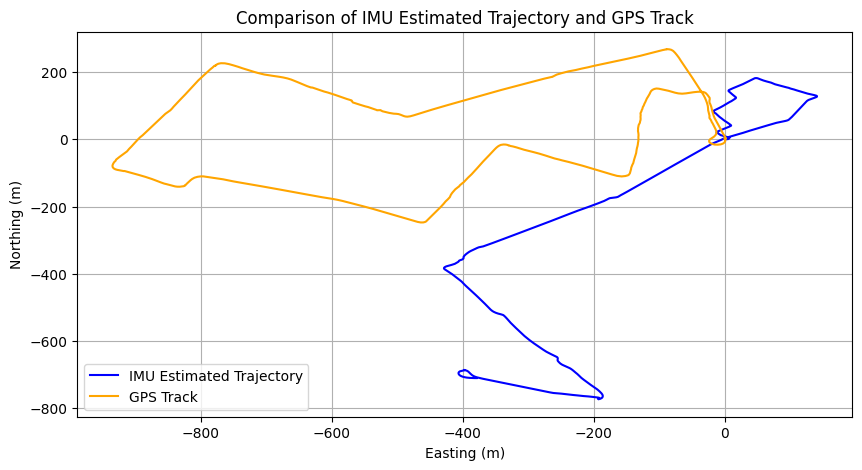

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.signal import butter, filtfilt
from gps_interfaces.msg import GPSmsg
from imu_interfaces.msg import IMUmsg
from rclpy.serialization import deserialize_message
import rosbag2_py
from rosidl_runtime_py.utilities import get_message

# Complementary filter parameter
alpha = 0.9  # Adjusted to give more weight to gyroscope data

def load_bag_data(bagfile_path):
    storage_options = rosbag2_py.StorageOptions(uri=bagfile_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions(input_serialization_format="cdr", output_serialization_format="cdr")
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)

    imu_data = []
    gps_data = []
    while reader.has_next():
        (topic, data, t) = reader.read_next()
        if topic == "/imu":
            imu_msg = deserialize_message(data, IMUmsg)
            imu_data.append(imu_msg)
        elif topic == "/gps":
            gps_msg = deserialize_message(data, GPSmsg)
            gps_data.append(gps_msg)
        
    return imu_data, gps_data

def lowpass_filter(data, cutoff_frequency, fs):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(N=1, Wn=normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def process_data(bagfile_path):
    imu_data, gps_data = load_bag_data(bagfile_path)

    imu_time = [msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9 for msg in imu_data]
    gyro_data = np.array([msg.imu.angular_velocity.z for msg in imu_data])  
    mag_data = np.array([[msg.mag_field.magnetic_field.x, msg.mag_field.magnetic_field.y] for msg in imu_data]) * 1e6

    # Magnetometer Calibration
    bias = np.mean(mag_data, axis=0)
    corrected_mag_data = mag_data - bias
    corrected_yaw_mag = np.arctan2(corrected_mag_data[:, 1], corrected_mag_data[:, 0])

    time_deltas = np.diff(imu_time)
    yaw_gyro = cumulative_trapezoid(gyro_data, dx=time_deltas, initial=0)

    # Complementary filter for yaw
    complementary_yaw = [corrected_yaw_mag[0]]
    for i in range(1, len(corrected_yaw_mag)):
        dt = imu_time[i] - imu_time[i - 1]
        gyro_yaw_estimate = complementary_yaw[-1] + gyro_data[i] * dt
        combined_yaw = alpha * gyro_yaw_estimate + (1 - alpha) * corrected_yaw_mag[i]
        complementary_yaw.append(combined_yaw)
    complementary_yaw = np.array(complementary_yaw)

    # Linear acceleration
    linear_acceleration = np.array([msg.imu.linear_acceleration.x for msg in imu_data])
    fs = 1.0 / np.mean(np.diff(imu_time))
    cutoff_frequency = 0.1
    filtered_acceleration = lowpass_filter(linear_acceleration, cutoff_frequency, fs)
    
    acceleration_bias = np.mean(filtered_acceleration[:100])
    corrected_acceleration = (filtered_acceleration - acceleration_bias) * 0.02

    # Integrating acceleration to obtain velocity
    imu_velocity = cumulative_trapezoid(corrected_acceleration, imu_time, initial=0)
    
    # Calculate IMU-based Easting and Northing using yaw
    ve = imu_velocity * np.cos(complementary_yaw)
    vn = imu_velocity * np.sin(complementary_yaw)

    gps_time = np.array([msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9 for msg in gps_data])
    utm_eastings = np.array([msg.utm_easting for msg in gps_data])
    utm_northings = np.array([msg.utm_northing for msg in gps_data])

    # Ensure GPS data is not empty
    if gps_time.size == 0 or utm_eastings.size == 0 or utm_northings.size == 0:
        print("No GPS data found. Exiting plot.")
        return

    # Integrate velocity to get position estimates from IMU
    x_e = cumulative_trapezoid(ve, imu_time, initial=0)
    x_n = cumulative_trapezoid(vn, imu_time, initial=0)

    # Initial alignment and yaw offset correction
    x_e -= x_e[0]
    x_n -= x_n[0]
    
    gps_easting = utm_eastings - utm_eastings[0]
    gps_northing = utm_northings - utm_northings[0]

    angle_offset = np.arctan2(gps_northing[1] - gps_northing[0], gps_easting[1] - gps_easting[0]) - complementary_yaw[0]
    
    # Apply rotation to align IMU trajectory with GPS
    rotated_x_e = x_e * np.cos(angle_offset) - x_n * np.sin(angle_offset)
    rotated_x_n = x_e * np.sin(angle_offset) + x_n * np.cos(angle_offset)

    # Plotting GPS and IMU trajectories for comparison
    plt.figure(figsize=(10, 5))
    
    plt.plot(rotated_x_e, rotated_x_n, label="IMU Estimated Trajectory", color='blue')
    
    plt.plot(gps_easting, gps_northing, label="GPS Track", color='orange')
    
    plt.xlabel("Easting (m)")
    
    plt.ylabel("Northing (m)")
    
    plt.title("Comparison of IMU Estimated Trajectory and GPS Track")
    
    plt.legend()
    
    plt.grid(True)
    
    plt.show()

# Path to the bag file
bagfile_path = "/home/rgautham20/lab4/data_driving.bag/data_driving.bag_0.db3"
process_data(bagfile_path)
